In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['GLOG_minloglevel']     = '2'
os.environ['TF_USE_LEGACY_KERAS']  = '1'

devnull = open(os.devnull, 'w')
old_stderr = sys.stderr
sys.stderr = devnull

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from collections import deque
from typing import Iterable
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm import trange
import warnings

tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')
sys.stderr = old_stderr
devnull.close()

In [3]:
for dev in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(dev, True)

In [4]:
def obtain_cifar10(verbose = False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0
    
    if verbose:
        print("---------------CIFAR10---------------")
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    return (X_train, y_train), (X_test, y_test)

def obtain_cifar100(verbose = False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
    y_train = keras.utils.to_categorical(y_train, 100)
    y_test = keras.utils.to_categorical(y_test, 100)
    
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0
    
    if verbose:
        print("---------------CIFAR100---------------")
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    return (X_train, y_train), (X_test, y_test)

In [5]:
def create_dense_nn(input_shape, width = 1024, num_classes = 10):
    inp = keras.Input(shape = input_shape, name = 'input')
    y = layers.Flatten()(inp)
    for i in range(5):
        y = layers.Dense(width, activation = None, name = f'dense_{i+1}')(y)
        y = layers.BatchNormalization(name = f'bn_{i+1}')(y)
        y = layers.Activation(tf.nn.relu, name = f'act_{i+1}')(y)
        
    y = layers.Dense(num_classes, activation = 'softmax', name = 'classifier_head')(y)
    
    return keras.Model(inputs = inp, outputs = y, name = 'dense_nn')

In [6]:
def create_vgg_nn(input_shape, num_classes = 10):
    print(f"Received `num_classes` = {num_classes}")
    inp = keras.Input(shape = input_shape, name = 'input')
    vgg_op = keras.applications.VGG16(
                                        include_top = False,
                                        weights = 'imagenet',
                                        input_tensor = None,
                                        input_shape = input_shape,
                                        pooling = "avg",
                                     )(inp)
    
    y = layers.Dense(num_classes, activation = 'softmax', name = 'classifier_head')(vgg_op)
    model = keras.Model(inputs = inp, outputs = y, name = 'vgg')
    return model

In [7]:
def get_minimum_loss(nn, loss_fn, train_data, metrics = None, batch_size = 32, num_epochs = 10):
    '''
    Trains the Neural Network specified by `nn` using Adam and finds minimum loss
    
    Arguments:
    -----------
        - nn: The neural network to train
        - loss_fn: The loss function to minimize.
        - train_data: A Tuple (X_train, y_train) where both X_train and y_train are numpy.ndarrays
                        -- X_train specifies the set of examples
                        -- y_train specifies the labels
        - metrics: Additional metrics to monitor (such as accuracy)
        - batch_size: batch size during training
        - num_epochs: Number of epochs to train
    
    Returns:
    ---------
    - The minimum loss
    - The list of loss values for every batch
    '''
    
    nn.compile(optimizer = 'sgd', loss = loss_fn, metrics = metrics)
    X_train, y_train = train_data
    assert isinstance(X_train, np.ndarray), f"X_train must be a numpy array. Found {type(X_train)}"
    assert isinstance(y_train, np.ndarray), f"y_train must be a numpy array. Found {type(y_train)}"
    assert X_train.shape[0] == y_train.shape[0], f"X_train and y_train must have same batch dimensions. Found X_train.shape: {X_train.shape} and y_train.shape: {y_train.shape}"
    
    num_batches = np.ceil(X_train.shape[0] / batch_size).astype(np.int32)
    loss_history = []
    
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        pbar = trange(num_batches)
        for batch_idx in range(num_batches):
            start = batch_idx * batch_size
            end = (batch_idx + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train[start:end]
            X_batch = tf.convert_to_tensor(X_batch, dtype = tf.float32)
            y_batch = tf.convert_to_tensor(y_batch, dtype = tf.float32)
            with tf.GradientTape() as tape:
                y_pred = nn(X_batch, training = True)
                loss = nn.compiled_loss(y_batch, y_pred)
            grads = tape.gradient(loss, nn.trainable_variables)
            nn.optimizer.apply_gradients(zip(grads, nn.trainable_variables))
            nn.compiled_metrics.update_state(y_batch, y_pred)
            metric_values = [f"{m.name}: {m.result().numpy():.4f}" for m in nn.metrics]
            message = " - ".join(metric_values)
            
            loss_history.append(nn.metrics[0].result().numpy())
            
            pbar.set_postfix_str(message)
            pbar.update(1)
            
        pbar.close()
    
    loss_history = np.asarray(loss_history)
    min_loss = loss_history.min()
    
    return min_loss, loss_history      
    

In [8]:
def train_nn(
                nn, 
                optimizer, 
                loss_fn, 
                train_data, 
                metrics = None, 
                batch_size = 32, 
                num_epochs = 10, 
                L_smoothness_iterations = 30,
                num_trace_vectors = 10
            ):
    """
    Trains the neural network and estimates both:
      (1) The L-smoothness constant (largest Hessian eigenvalue 
          w.r.t. model parameters) via power iteration
      (2) The Hessian trace via Hutchinson's method
    in the same training loop (so no separate pass is needed).

    Arguments:
    ----------
    nn : tf.keras.Model
    optimizer : tf.keras.optimizers.Optimizer
    loss_fn : Callable like tf.keras.losses.*
    train_data : (X_train, y_train) as numpy arrays
    metrics : list of Keras metrics or None
    batch_size : int
    num_epochs : int
    num_trace_vectors : number of random vectors for Hutchinson's trace estimator

    Returns:
    --------
    loss_values : list of float
        Loss at each iteration
    gradient_norms : list of float
        Grad-norm at each iteration
    trace_vals_hessian : list of float
        Estimated Hessian trace per iteration
    learning_rate_schedule : list of float
        Learning rate history
    """
    
    nn.compile(optimizer = optimizer, loss = loss_fn, metrics = metrics)
    X_train, y_train = train_data
    assert isinstance(X_train, np.ndarray), f"X_train must be a numpy array. Found {type(X_train)}"
    assert isinstance(y_train, np.ndarray), f"y_train must be a numpy array. Found {type(y_train)}"
    
    gradient_norms = []
    loss_values = []
    trace_vals_hessian = []
    learning_rate_schedule = []
    
    num_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    
    iteration = 0
    max_iters = num_batches * num_epochs
    eta0 = optimizer.learning_rate.numpy()
    
    learning_rate_schedule.append(eta0)
    
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        
        for batch_idx in range(num_batches):
            # ------------------ Get the current mini-batch ------------------
            start = batch_idx * batch_size
            end = min((batch_idx + 1) * batch_size, num_samples)
            X_batch, y_batch = X_train[start:end], y_train[start:end]
            
            # ------------------ 1) Forward + Backward pass (training) ------------------
            with tf.GradientTape() as tape:
                y_pred = nn(X_batch, training = True)
                loss = loss_fn(y_batch, y_pred)
            grads = tape.gradient(loss, nn.trainable_variables)
            optimizer.apply_gradients(zip(grads, nn.trainable_variables))
            
            grad_norm = tf.linalg.global_norm(grads)
            
            # ------------------ 3) Estimate Hessian trace (Hutchinson's method) ------------------
            #
            # We do num_trace_vectors random vectors z (default = 10).
            # For each z: compute z^T (H z) using the double-gradient approach.
            # Then average them.
            trace_vals = []
            for _ in range(num_trace_vectors):
                # Sample a random vector z matching shapes of each parameter
                z_list = [tf.random.normal(tf.shape(var)) for var in nn.trainable_variables]
                
                # double-backprop to get z^T H z
                with tf.GradientTape() as tape2:
                    with tf.GradientTape() as tape1:
                        y_pred_inner = nn(X_batch, training = True)
                        loss_inner = loss_fn(y_batch, y_pred_inner)
                    grads_inner = tape1.gradient(loss_inner, nn.trainable_variables)
                    
                    directional_deriv_z = tf.add_n([tf.reduce_sum(g * z) for g, z in zip(grads_inner, z_list)])
                
                hvp_z = tape2.gradient(directional_deriv_z, nn.trainable_variables)
                hvp_z = [
                            tf.zeros_like(vv) if (hvp_zi is None) else hvp_zi
                            for vv, hvp_zi in zip(nn.trainable_variables, hvp_z)
                        ]
                
                # z^T (H z)
                zHz = tf.add_n([
                                    tf.reduce_sum(z * h) for z, h in zip(z_list, hvp_z)
                               ])
                trace_vals.append(zHz)
            
            # Take the average as the trace estimate
            trace_estimate = tf.reduce_max(trace_vals).numpy()
            
            # ------------------ Book-keeping & Logs ------------------
            gradient_norms.append(grad_norm.numpy())
            loss_values.append(loss.numpy())
            trace_vals_hessian.append(trace_estimate)
            
            iteration += 1
            
            # LR decay after some fraction of training
            if iteration >= int(0.7 * max_iters):
                new_lr = eta0 * np.exp(-0.01 * iteration)
                optimizer.learning_rate.assign(new_lr)
                learning_rate_schedule.append(new_lr)
            else:
                learning_rate_schedule.append(eta0)
            
            print(
                    f" Batch {batch_idx + 1}/{num_batches}: "
                    f"LR = {optimizer.learning_rate.numpy():.5f}, "
                    f"Loss = {loss.numpy():.4f}, "
                    f"||Grad|| = {grad_norm.numpy():.4f}, "
                    f"Trace(H) ~ {trace_estimate:.4f}"
                 )
            
    return loss_values, gradient_norms, trace_vals_hessian, learning_rate_schedule

In [9]:
def find_min_L_smoothness_constant(
    nn, 
    optimizer, 
    loss_fn, 
    train_data, 
    metrics = None, 
    batch_size = 32, 
    num_epochs = 10, 
    L_smoothness_iterations = 30
):
    """
    Trains the neural network and estimates both:
      (1) The L-smoothness constant (largest Hessian eigenvalue 
          w.r.t. model parameters) via power iteration
      (2) The Hessian trace via Hutchinson's method
    in the same training loop (so no separate pass is needed).

    Arguments:
    ----------
    nn : tf.keras.Model
    optimizer : tf.keras.optimizers.Optimizer
    loss_fn : Callable like tf.keras.losses.*
    train_data : (X_train, y_train) as numpy arrays
    metrics : list of Keras metrics or None
    batch_size : int
    num_epochs : int
    L_smoothness_iterations : number of power iterations to estimate top eigenvalue

    Returns:
    --------
    loss_values : list of float
        Loss at each iteration
    gradient_norms : list of float
        Grad-norm at each iteration
    eig_vals_hessian : list of float
        Estimated largest Hessian eigenvalue per iteration
    learning_rate_schedule : list of float
        Learning rate history
    """
    
    nn.compile(optimizer = optimizer, loss = loss_fn, metrics = metrics)
    X_train, y_train = train_data
    assert isinstance(X_train, np.ndarray), f"X_train must be a numpy array. Found {type(X_train)}"
    assert isinstance(y_train, np.ndarray), f"y_train must be a numpy array. Found {type(y_train)}"
    
    gradient_norms = []
    loss_values = []
    eig_vals_hessian = []
    learning_rate_schedule = []
    
    num_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    
    iteration = 0
    max_iters = num_batches * num_epochs
    eta0 = optimizer.learning_rate.numpy()
    
    learning_rate_schedule.append(eta0)
    
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        
        for batch_idx in range(num_batches):
            # ------------------ Get the current mini-batch ------------------
            start = batch_idx * batch_size
            end = min((batch_idx + 1) * batch_size, num_samples)
            X_batch, y_batch = X_train[start:end], y_train[start:end]
            
            # ------------------ 1) Forward + Backward pass (training) ------------------
            with tf.GradientTape() as tape:
                y_pred = nn(X_batch, training = True)
                loss = loss_fn(y_batch, y_pred)
            grads = tape.gradient(loss, nn.trainable_variables)
            optimizer.apply_gradients(zip(grads, nn.trainable_variables))
            
            grad_norm = tf.linalg.global_norm(grads)
            
            # ------------------ 2) Estimate largest Hessian eigenvalue (Power Iteration) ------------------
            
            # Initialize v as random, shape-matching each parameter
            v = [tf.random.normal(tf.shape(var)) for var in nn.trainable_variables]
            norm_v = tf.linalg.global_norm(v)
            if norm_v > 0:
                v = [vi / norm_v for vi in v]  # normalize
            
            # Repeatedly compute Hv and normalize
            for _ in range(L_smoothness_iterations):
                # directional derivative v^T grad(loss)
                with tf.GradientTape() as tape2:
                    with tf.GradientTape() as tape1_inner:
                        y_pred_inner = nn(X_batch, training = True)
                        loss_inner = loss_fn(y_batch, y_pred_inner)
                    grads_inner = tape1_inner.gradient(loss_inner, nn.trainable_variables)
                    directional_deriv = tf.add_n([
                        tf.reduce_sum(g * vi) for g, vi in zip(grads_inner, v)
                    ])
                hv = tape2.gradient(directional_deriv, nn.trainable_variables)
                hv = [tf.zeros_like(var) if h is None else h 
                      for var, h in zip(nn.trainable_variables, hv)]
                norm_hv = tf.linalg.global_norm(hv)
                if norm_hv == 0:
                    break
                v = [h / norm_hv for h in hv]
            
            # Final Rayleigh quotient: v^T (H v)
            with tf.GradientTape() as tape2:
                with tf.GradientTape() as tape1_inner:
                    y_pred_inner = nn(X_batch, training=True)
                    loss_inner = loss_fn(y_batch, y_pred_inner)
                grads_inner = tape1_inner.gradient(loss_inner, nn.trainable_variables)
                directional_deriv = tf.add_n([
                    tf.reduce_sum(g * vi) for g, vi in zip(grads_inner, v)
                ])
            hv = tape2.gradient(directional_deriv, nn.trainable_variables)
            hv = [tf.zeros_like(var) if h is None else h 
                  for var, h in zip(nn.trainable_variables, hv)]
            eigen_estimate = tf.add_n([
                tf.reduce_sum(vi * hi) for vi, hi in zip(v, hv)
            ])
            largest_eig_val = abs(eigen_estimate.numpy())
            
            # ------------------ Book-keeping & Logs ------------------
            gradient_norms.append(grad_norm.numpy())
            loss_values.append(loss.numpy())
            eig_vals_hessian.append(largest_eig_val)
            
            iteration += 1
            
            # (Optional) simple LR decay after some fraction of training
            if iteration >= int(0.7 * max_iters):
                new_lr = eta0 * np.exp(-0.01 * iteration)
                optimizer.learning_rate.assign(new_lr)
                learning_rate_schedule.append(new_lr)
            else:
                learning_rate_schedule.append(eta0)
            
            print(
                f" Batch {batch_idx + 1}/{num_batches}: "
                f"LR = {optimizer.learning_rate.numpy():.5f}, "
                f"Loss = {loss.numpy():.4f}, "
                f"||Grad|| = {grad_norm.numpy():.4f}, "
                f"L-smoothness-constant ~ {largest_eig_val:.4f}, "
            )
            
    return loss_values, gradient_norms, eig_vals_hessian, learning_rate_schedule

In [10]:
def estimate_minimum_L_smoothness_constant(nn_type = 'dense',
                                           data = 'cifar10',
                                           optimizer_init_learning_rate = 0.01,
                                           optimizer_momentum = 0.99,
                                           L_estimator_iterations = 30,
                                           batch_size = 1024,
                                           num_epochs = 20):
    if data == 'cifar10':
        (X_train, y_train), _ = obtain_cifar10()
    elif data == 'cifar100':
        (X_train, y_train), _ = obtain_cifar100()
    else:
        raise ValueError(f"`data` argument must be either 'cifar10' or 'cifar100'. Found {data}")
    
    if nn_type == 'dense':
        nn = create_dense_nn(input_shape = X_train.shape[1:], width = 1024, num_classes = y_train.shape[1])
    elif nn_type == 'vgg':
        nn = create_vgg_nn(input_shape = X_train.shape[1:], num_classes = y_train.shape[1])
    else:
        raise ValueError(f"`nn_type` argument must be either 'dense' or 'vgg'. Found {nn_type}")
    
    optimizer = keras.optimizers.Adam(learning_rate = optimizer_init_learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = False, name = 'loss')
    losses, grad_norms, eig_vals_hessian, learning_rate_schedule = find_min_L_smoothness_constant(nn, optimizer, loss, 
                                                                                                  train_data = (X_train, y_train),
                                                                                                  batch_size = batch_size, num_epochs = num_epochs,
                                                                                                  L_smoothness_iterations = L_estimator_iterations)
    eig_vals_hessian = np.asarray(eig_vals_hessian)
    losses = np.asarray(losses)
    grad_norms = np.asarray(grad_norms)
    learning_rate_schedule = np.asarray(learning_rate_schedule)
    
    print(f"Estimated Minimum L-smoothness constant: {eig_vals_hessian.min():.4f}")
    
    return eig_vals_hessian.min()

In [11]:
def estimate_pl_constant(nn_type = 'dense',
                         data = 'cifar10',
                         batch_size = 4096,
                         optimizer_init_learning_rate = 1e-4,
                         num_epochs = 20,
                         burnin_steps = 0,
                         min_loss_gap = 0.05,
                         display_ncols = 50):
    
    if data == 'cifar10':
        (X_train, y_train), _ = obtain_cifar10()
    elif data == 'cifar100':
        (X_train, y_train), _ = obtain_cifar100()
    else:
        raise ValueError(f"`data` argument must be either 'cifar10' or 'cifar100'. Found {data}")
    
    if nn_type == 'dense':
        nn = create_dense_nn(input_shape = X_train.shape[1:], width = 1024, num_classes = y_train.shape[1])
    elif nn_type == 'vgg':
        nn = create_vgg_nn(input_shape = X_train.shape[1:], num_classes = y_train.shape[1])
    else:
        raise ValueError(f"`nn_type` argument must be either 'dense' or 'vgg'. Found {nn_type}")
    
    optimizer = keras.optimizers.Adam(learning_rate = optimizer_init_learning_rate)
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits = False, name = 'loss')
    
    grad_norms = []
    losses = []
    
    num_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    
    iteration = 0
        
    for i in range(1, num_epochs + 1):
        print(f"Epoch {i:03d}/{num_epochs:03d}")
                
        idx = np.random.permutation(num_samples)
        X_train, y_train = X_train[idx], y_train[idx]
        
        pbar = trange(num_batches, ncols = display_ncols, ascii = '.>=')        
        for batch_idx in range(num_batches):            
            iteration += 1
            start = batch_idx * batch_size
            end = min((batch_idx + 1) * batch_size, num_samples)
            X_batch, y_batch = X_train[start:end], y_train[start:end]
            
            with tf.GradientTape() as tape:
                y_pred = nn(X_batch, training = True)
                loss = loss_fn(y_batch, y_pred)
            
            grads = tape.gradient(loss, nn.trainable_variables)
            optimizer.apply_gradients(zip(grads, nn.trainable_variables))

            grad_norms.append(tf.linalg.global_norm(grads).numpy())
            losses.append(loss.numpy())
            
            pbar.set_postfix_str(f'step: {iteration} - loss: {loss.numpy():4f}')
            pbar.update(1)
        
        pbar.close()

    losses = np.asarray(losses, dtype = np.float64)
    grad_norms_sq = np.asarray(grad_norms, dtype = np.float64) ** 2
    
    if burnin_steps > 0:
        losses = losses[burnin_steps:]
        grad_norms_sq = grad_norms_sq[burnin_steps:]

    # --- no-intercept fit ---
    f_star = float(np.min(losses))

    x = np.maximum(losses - f_star, 0.0)
    
    mask = x > min_loss_gap
    if np.any(mask):
        x = x[mask]
        losses = losses[mask]
        grad_norms_sq = grad_norms_sq[mask]    
    
    ratios = grad_norms_sq / (2.0 * np.maximum(x, 1e-12))  # each gives an admissible μ
    mu_estimate = float(np.min(ratios))

    print(f"Estimated PL-constant (mu): {mu_estimate:.6f}  ;  f*: {f_star:.6f}")

    # --- visualization ---
    # y = grad_norms_sq
    # fig, ax = plt.subplots(1, 1, figsize = (8, 8))
    # ax.scatter(x, y, s = 10, label = 'observations')
    # # line through origin in (x, y): y_hat = slope * x
    # xs = np.linspace(0.0, float(x.max()), 200)
    # ax.plot(xs, 2.0 * mu_estimate * xs, label = r'$y=2\mu x$', linewidth = 2)
    # ax.set_xlabel(r'$f(\theta)-f_\star$', fontsize = 16)
    # ax.set_ylabel(r'$\|\nabla f(\theta)\|^2$', fontsize = 16)
    # ax.tick_params(axis = 'both', labelsize = 14)
    # ax.legend()
    # fig.tight_layout()

    return mu_estimate

In [12]:
def estimate_hessian_trace(nn_type = 'dense', 
                           data = 'cifar10',
                           optimizer_init_learning_rate = 1e-4,  
                           num_trace_vectors = 20,
                           batch_size = 16384,
                           num_epochs = 20):
    
    if data == 'cifar10':
        (X_train, y_train), _ = obtain_cifar10()
    elif data == 'cifar100':
        (X_train, y_train), _ = obtain_cifar100()
    else:
        raise ValueError(f"`data` argument must be either 'cifar10' or 'cifar100'. Found {data}")
    
    if nn_type == 'dense':
        nn = create_dense_nn(input_shape = X_train.shape[1:], width = 1024, num_classes = y_train.shape[1])
    elif nn_type == 'vgg':
        nn = create_vgg_nn(input_shape = X_train.shape[1:], num_classes = y_train.shape[1])
    else:
        raise ValueError(f"`nn_type` argument must be either 'dense' or 'vgg'. Found {nn_type}")
    
    optimizer = keras.optimizers.Adam(learning_rate = optimizer_init_learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = False, name = 'loss')
    losses, grad_norms, trace_vals_hessian, learning_rate_schedule = train_nn(nn, optimizer, loss, 
                                                                              train_data = (X_train, y_train),
                                                                              batch_size = batch_size, num_epochs = num_epochs,
                                                                              num_trace_vectors = num_trace_vectors)

    losses = np.asarray(losses)
    trace_vals_hessian = np.asarray(trace_vals_hessian)
    learning_rate_schedule = np.asarray(learning_rate_schedule)
                       
    hessian_trace_estimate = trace_vals_hessian.mean()          # Hutchinson's is unbiased only for mean **NOT** for max estimate
    
    print(f"Estimated Maximum Trace of Hessian: {trace_vals_hessian.max():.4f}, Estimated Mean Trace of Hessian: {trace_vals_hessian.mean():.4f}")
    
    return (None, hessian_trace_estimate), trace_vals_hessian

In [13]:
def build_block_ids(n, max_delay, start = 0):
    """
    Vectorised block labels 0 … K-1 for every step 1 … n.
    `start` denotes t_0 or tau_M.
    """
    return tf.range(start, n, delta = 1, dtype = tf.int32) // (max_delay + 1)


def _envelope_over_blocks(eta, block_ids, tau_M = 0, is_max = True):
    """
    eta        : (N , n)
    block_ids  : (n,)  int32 labels 0 … K-1
    returns    : (N , K)   η_max or η_min per block
    """
    eta_T = tf.transpose(eta[:, tau_M:])              # (n , N)
    K = tf.reduce_max(block_ids) + 1                  # scalar
    if is_max:
        env_T = tf.math.unsorted_segment_max(eta_T, block_ids, K)
    else:
        env_T = tf.math.unsorted_segment_min(eta_T, block_ids, K)
    return tf.transpose(env_T)                 # (N , K)


# ──────────────────────────────────────────────────────────────────────────────
#  κ(K)  of Theorem 2   (vectorised, XLA‑friendly)
# ──────────────────────────────────────────────────────────────────────────────
@tf.function(jit_compile = True)
def kappa_fn_tf(eta,          # (N , n)   step sizes per trajectory
                mu, L, sigma_sq,
                T,            # horizon (scalar)
                G_local,      # (N,)  or scalar broadcastable to (N ,1)
                hess_tr,      # (N,)  trace of Hessian ‖∇²f‖₁
                tau_M,        # t₀  (scalar)
                block_ids,    # (n,)  int32 labels 0…K-1
                delta_t = 1.0):
    """
    Vectorised computation of κ(K) from Theorem 2 for an (N × n) batch of step
    sequences divided into K blocks.

    Returns
    -------
    kappa      : (N,)        sum over blocks
    kappa_part : (N , K)     contribution of each block
    """
    # --- common casts ---------------------------------------------------------
    dtype = eta.dtype
    mu, L = tf.cast(mu, dtype), tf.cast(L, dtype)
    sigma_sq = tf.cast(sigma_sq, dtype)
    T = tf.cast(T, dtype)
    G_local = tf.cast(G_local, dtype)[:, None]         # (N , 1)
    hess_tr = tf.cast(hess_tr, dtype)
    dt = tf.cast(delta_t, dtype)
    
    block_ids -= tf.reduce_min(block_ids)

    # --- η_max and η_min for every block --------------------------------------
    eta_max = _envelope_over_blocks(eta, block_ids, tau_M = tau_M, is_max = True)   # (N , K)
    eta_min = _envelope_over_blocks(eta, block_ids, tau_M = tau_M, is_max = False)  # (N , K)

    # --- block lengths and start times ----------------------------------------
    # Nj = #steps in block j  →  (K,)
    Nj = tf.math.unsorted_segment_sum(
                                        data = tf.ones_like(block_ids, dtype=tf.int32),
                                        segment_ids = block_ids,
                                        num_segments = tf.reduce_max(block_ids) + 1
                                     )

    Nj_dt  = tf.cast(Nj, dtype) * dt                      # (K,)
    d      = tf.expand_dims(Nj_dt, 0)                     # (1 , K)  for broadcast

    # start_times_j = Σ_{ℓ<j} Nℓ·dt  →  (K,)
    start_times = tf.cumsum(Nj_dt, exclusive = True)
    start_times = tf.expand_dims(start_times, 0)         # (1 , K) broadcast

    # --- log-prefactor ---------------------------------------------------------
    log_pref = -mu * eta_max * tau_M - tf.math.log(mu * eta_max)

    # --- stable log(exp(a) − exp(b)) ------------------------------------------
    a =  mu * (eta_max - eta_min) * d          # (N , K)
    b = -mu *  eta_min * d                     # (N , K)
    m = tf.minimum(a, b)
    M = tf.maximum(a, b)
    log_diff_inner = M + tf.math.log1p(-tf.exp(m - M))

    # complete difference term (add μη_max·t_j)
    log_diff = mu * eta_max * start_times + log_diff_inner

    # --- constant term inside the bracket -------------------------------------
    term1 = 0.5 * L**2 * eta_max**3 * (T**2 * G_local**2 + sigma_sq * T)
    term2 = 0.5 * sigma_sq * eta_max**2 * hess_tr
    log_const = tf.math.log(term1 + term2)

    # --- assemble and reduce ---------------------------------------------------
    log_kappa_part = log_pref + log_diff + log_const      # (N , K)
    kappa_part = tf.exp(log_kappa_part)                   # (N , K)
    kappa = tf.reduce_sum(kappa_part, axis=1)             # (N ,)

    return kappa, kappa_part



# ──────────────────────────────────────────────────────────────────────────────
#  log‑bound and objective
# ──────────────────────────────────────────────────────────────────────────────
@tf.function(jit_compile = True)
def log_bound_batched_tf(eta_mat, f0_batch, mu, kappa):
    Sn = tf.reduce_sum(eta_mat, axis = 1)
    term1 = tf.math.log(f0_batch) - mu * Sn
    term2 = tf.math.log(kappa)
    return tf.maximum(term1, term2) + tf.math.log1p(tf.exp(-tf.abs(term1 - term2)))


@tf.function(jit_compile = True)
def objective_log_bound_squared_batched_tf(eta_mat, f0_batch, mu, kappa):
    log_b = log_bound_batched_tf(eta_mat, f0_batch, mu, kappa)
    two_log_b = 2.0 * log_b
    max_l = tf.reduce_max(two_log_b)
    return tf.exp(tf.math.log(tf.reduce_sum(tf.exp(two_log_b - max_l))) + max_l)

def eta_fn(suboptimality_gap, k, mu, L, sigma_sq, G_local, T, H_max = None, clip_factor = 0.1):
    '''
        Fixes learning rate to `clip_factor` of the prescribed upper-bound from Theorem 2.
            - suboptimality_gap: Shape: (num_initializations, )
            - k                : int
            - L                : float
            - sigma_sq         : float
            - G_local          : float
            - T                : int
            - clip_factor      : fraction of upper-bound to clip the learning rate to
        
        Returns:
            - scalar learning rate of shape ()
    '''   
    Vt = tf.reduce_mean(suboptimality_gap)
    H_max = k * L if H_max is None else H_max
    a = L**2 * T**2 * G_local**2 + L**2 * sigma_sq * T
    
    eta_hi = (-sigma_sq * H_max + tf.math.sqrt(sigma_sq**2 * H_max**2 + 16 * mu * Vt * a)) / (2 * a)
        
    return clip_factor * eta_hi


@tf.function
def discrete_time_pl_bound_fast_tf(f0, kappa, mu, eta, tau_M = 0):
    '''
    Returns a tensor 'bounds' of length N+1

    We do a stable summation of exp(...) to avoid overflow, and we allow
    e^{- mu sum(eta)} to underflow to 0 if the sum is huge (which is usually safe).

    Arguments
    ----------
    f0         : float
                 f(theta(0)) - f(theta^*)
    kappa      : float
                 noise-term constant from the PL bound. Shape (n, )
    mu         : float
                 the PL (Polyak-Łojasiewicz) constant
    eta        : tf.Tensor or np.ndarray of shape (n, )
                 the discrete step sizes. 

    Returns
    -------
    bounds : tf.Tensor of shape (n+1,)
             The bound at each iteration n=0..n, inclusive.
             bounds[0] = f0, and bounds[k] for k>0 is the bound after k steps.
    '''
    # Convert eta to a TensorFlow tensor with float32 precision.
    eta = tf.convert_to_tensor(eta, dtype = tf.float32)[tau_M:]
    
    # Compute the cumulative sum of the step sizes.
    cumsum_eta = tf.math.cumsum(eta)  # shape: (n,)
    
    # For n = 1,...,n, compute the bound:
    # f0 * exp(-mu * (sum of eta over the k steps)) + kappa.
    bounds_without_initial = f0 * tf.exp(- mu * cumsum_eta) + kappa  # shape: (n,)
    
    # Prepend the initial f0 value.
    f0_tensor = tf.reshape(tf.convert_to_tensor(f0, dtype = tf.float32), [1])
    bounds = tf.concat([f0_tensor, bounds_without_initial], axis = 0)  # shape: (n+1,)
    
    return bounds

In [14]:
def evaluate_objective(nn, loss_fn, X, y, batch_size = 4096):
    if batch_size <= 0:
        num_batches = 1
        batch_size = X.shape[0]
    else:
        num_batches = np.ceil(X.shape[0] / batch_size).astype(np.int32)
    losses = []
    for batch_idx in range(num_batches):
        y_pred = nn(X[batch_idx * batch_size: (batch_idx + 1) * batch_size], training = False)
        loss_batch = call_loss(loss_fn, y[batch_idx * batch_size: (batch_idx + 1) * batch_size], y_pred)
        losses.append(loss_batch)
    
    return tf.reduce_mean(losses)

def call_loss(loss_fn, y_true, y_pred):
    # Respect the loss's own reduction
    red = getattr(loss_fn, "reduction", None)
    if red in (tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
               tf.keras.losses.Reduction.AUTO,
               None):
        return loss_fn(y_true, y_pred)            # already averaged
    elif red == tf.keras.losses.Reduction.NONE:
        return tf.reduce_mean(loss_fn(y_true, y_pred))
    elif red == tf.keras.losses.Reduction.SUM:
        # normalize to mean for comparable scale
        vals = loss_fn(y_true, y_pred)
        return vals / tf.cast(tf.shape(y_true)[0], vals.dtype)
    else:
        return loss_fn(y_true, y_pred)


def evaluate_gradient(nn, loss_fn, X, y):
    with tf.GradientTape() as tape:
        y_pred = nn(X, training = False)
        loss_batch = call_loss(loss_fn, y, y_pred)
    gradient = tape.gradient(loss_batch, nn.trainable_variables)
    
    return gradient, loss_batch


def clone_with_weights(base):
    new = keras.models.clone_model(base)
    new.build(base.input_shape)
    new.set_weights(base.get_weights())
    return new

def grad_and_sq_microbatch(model, loss_fn, Xb, yb, vars_list = None, chunks = 8):
    if vars_list is None:
        vars_list = model.trainable_variables
    n = int(Xb.shape[0])
    m = max(1, min(int(chunks), n))
    base = n // m
    sizes = [base]*(m-1) + [n - base*(m-1)]
    Xs = tf.split(Xb, sizes, axis = 0)
    ys = tf.split(yb, sizes, axis = 0)

    grads_lists = [[] for _ in vars_list]
    bsizes = []

    for Xc, yc in zip(Xs, ys):
        with tf.GradientTape() as tape:
            preds = model(Xc, training = True)
            loss  = call_loss(loss_fn, yc, preds)  # see §4 below
        gc = tape.gradient(loss, vars_list)
        for i, (g, v) in enumerate(zip(gc, vars_list)):
            if g is None: g = tf.zeros_like(v)
            grads_lists[i].append(g)
        bsizes.append(int(Xc.shape[0]))

    # mean grad over whole batch
    g_mean_list = [tf.reduce_mean(tf.stack(gs, axis = 0), axis = 0) for gs in grads_lists]

    # mean of per-example squared grads: (1/N) * sum_j b_j * (g_mean_j)^2
    N = float(n)
    g2_mean_list = []
    for gs in grads_lists:
        g_means = tf.stack(gs, axis = 0)  # [m, ...]
        b = tf.constant(bsizes, dtype=g_means.dtype)
        b = tf.reshape(b, [tf.shape(g_means)[0]] + [1] * (len(g_means.shape) - 1))
        g2_mean = tf.reduce_sum(b * tf.square(g_means), axis = 0) / N
        g2_mean_list.append(g2_mean)
    return g_mean_list, g2_mean_list



In [15]:
def asgd(
            nn,
            mu,
            L,
            hessian_trace,
            max_delay,
            sigma_sq,
            iterations = 1000,
            eta_init_schedule = None,
            dc_asgd_schedule = None,
            M_frac = None,
            dynamic_lr = True,
            clip_factor = 0.9,
            clip_value = None,
            enable_dcasgd = True,
            enable_sgd = True,
            dcasgd_alpha = 0.05,
            dcasgd_beta = 0.999,
            clip_delta_norm = None,
            clip_v_value = None,
            **kwargs
        ):
    """
    Simulates Asynchronous SGD (A-SGD) on a neural network objective, with possible gradient delays/loss.
    
    Parameters
    ----------
    nn : tf.keras.Model
        The neural network as the objective.
    mu : float
        Strong-convexity or related parameter (if used).
    L : float
        Lipschitz constant (or an upper bound on gradient norms).
    hessian_trace : float
        Trace of the Hessian (if relevant to your schedule).
    max_delay : int
        Maximum possible delay. Actual delay drawn from Unif[0, max_delay].
    sigma_sq : float or array-like
        Gradient noise variance or array of per-step variances.
    iterations : int
        Number of training iterations.
    eta_schedule : callable or None
        If provided, a function that takes `iterations` and returns an array-like of LRs.
    
    Additional Keyword Args
    -----------------------
    train_data : tuple (X, y)
        Required for training. X and y are np.ndarrays or tf.Tensors of data and labels.
    loss_fn : tf.keras.losses.Loss
        The loss criterion. Required.
    batch_size : int, default = 4096
        Batch size for mini-batch gradient computations.
    apply_momentum: bool, default = False
        If True then apply momentum to SGD.

    Returns
    -------
    trajectory_f_async : list of floats
        The loss at each iteration (measured on the mini-batch used that step).
    eta_used : np.ndarray
        The array of learning rates used at each iteration.
    """

    train_data = kwargs.pop('train_data', None)
    loss_fn = kwargs.pop('loss_fn', None)
    batch_size = kwargs.pop('batch_size', 4096)
    apply_momentum = kwargs.pop('apply_momentum', False)
    nesterov_momentum = kwargs.pop('nesterov_momentum', False)
    apply_dc_momentum = kwargs.pop('apply_dc_momentum', False)
    
    print(f"A-SGD batch size: {batch_size}")

    if train_data is None:
        raise ValueError("Expected train_data=(X, y). Found None.")
    X, y = train_data

    if loss_fn is None:
        raise ValueError("Expected a loss function. Found None.")
    
    if eta_init_schedule is None:
        raise ValueError(f"eta_init_schedule must be provided")
    
    if dc_asgd_schedule is None:
        raise ValueError(f"dc_asgd_schedule must be provided")

    if not isinstance(M_frac, Iterable):
        M_frac = [M_frac]
    
    M_frac = np.asarray(M_frac).astype(np.float32)
    M_frac_sorted = np.sort(np.asarray(M_frac).astype(np.float32))[::-1]
    
    if not np.array_equal(M_frac, M_frac_sorted):
        raise ValueError(f"If providing an iterable for M_frac, ensure it is sorted in descending order.")
    
    del M_frac_sorted
    
    sigma_arr = tf.fill(dims = (iterations,), value = sigma_sq)

    num_samples = X.shape[0]
    num_batches = np.ceil(num_samples / batch_size)
    k = nn.count_params()

    current_batch_index = lambda k: int(k % num_batches)
    
    init_batch_idx = current_batch_index(0)    

    X_batch_init = X[init_batch_idx * batch_size : (init_batch_idx + 1) * batch_size]
    y_batch_init = y[init_batch_idx * batch_size : (init_batch_idx + 1) * batch_size]
    f0_batch = evaluate_objective(nn, loss_fn, X_batch_init, y_batch_init, batch_size = batch_size).numpy()
    
    def make_sgd(lr):
        mom = 0.99 if apply_momentum else 0.0
        return keras.optimizers.SGD(learning_rate = lr, momentum = mom, nesterov = nesterov_momentum)        
    
    init_lr = eta_init_schedule(0)
    
    opt_async  = make_sgd(init_lr)
    opt_dcasgd = make_sgd(init_lr) if enable_dcasgd else None
    opt_sync   = make_sgd(init_lr) if enable_sgd else None
        
    q_async = deque(maxlen = max_delay + 1)         # stores gradients only
    q_dcasgd = deque(maxlen = max_delay + 1)        # stores (gradients, model_snapshots)
    
    trajectory_f_async = [f0_batch]
    trajectory_f_sync  = [f0_batch] if enable_sgd else None
    trajectory_f_dcasgd = [f0_batch] if enable_dcasgd else None
    
    grad_norms_collected = []
    eta_used = []

    print(f"\n[A-SGD start] mu = {mu:.4f}, L = {L:.4f}, max_delay = {max_delay}, iterations = {iterations}")
    delay_sum = 0
    G_local = [None for _ in M_frac]
    tau_M = [None for _ in M_frac]
    
    last_M_frac_idx = 0
    
    nn_async  = clone_with_weights(nn)
    nn_dcasgd = clone_with_weights(nn) if enable_dcasgd else None
    nn_sync   = clone_with_weights(nn) if enable_sgd else None
    
    switched = False
    
    pbar = trange(iterations, desc = "A-SGD", leave = True)
    for i in pbar:
        step_idx = i + 1
        b_idx = current_batch_index(i)
        X_batch = X[b_idx * batch_size : (b_idx + 1) * batch_size]
        y_batch = y[b_idx * batch_size : (b_idx + 1) * batch_size]
        
        if enable_dcasgd:
        # take a detached snapshot *before* computing the gradient
            snap_dca = [tf.stop_gradient(v.read_value()) for v in nn_dcasgd.trainable_variables]
            g_dca, _ = evaluate_gradient(nn_dcasgd, loss_fn, X_batch, y_batch)
            q_dcasgd.append((g_dca, snap_dca))
        
        current_grad_async, _ = evaluate_gradient(nn_async, loss_fn, X_batch, y_batch)
        
        if enable_sgd:
            current_grad_sync, _ = evaluate_gradient(nn_sync, loss_fn, X_batch, y_batch)
            opt_sync.apply_gradients(zip(current_grad_sync, nn_sync.trainable_variables))
            
        q_async.append(current_grad_async)

        delay = int(tf.random.uniform(minval = 0, maxval = max_delay + 1, shape = (), dtype = tf.int32).numpy()) if max_delay > 0 else 0
        delay_sum += delay

        # If we have enough old gradients in the queue, fetch delayed_grad
        # Otherwise, we simulate "lost" gradient => skip update
        if delay < len(q_async):
            delayed_grad = q_async[-(delay + 1)]  # "delay steps behind"
        else:
            delayed_grad = None  # Not enough old grads => skip
        
        if enable_dcasgd and delay < len(q_dcasgd):
            g_delayed, snap = q_dcasgd[-(delay + 1)]

            lr_t  = float(opt_dcasgd.learning_rate.numpy())
            lamda = float(kwargs.get("dcasgd_lambda", 0.04))            # start 0.01–0.05 if LR is small
            wd    = float(kwargs.get("dcasgd_weight_decay", 0.0))
            clipg = kwargs.get("dcasgd_clip_gradient", None)            # e.g., 1.0 or None

            # ---- build raw DC term with correct Δw (snapshot-based) ----
            dc_terms = []
            base_dirs = []
            for w, g, w_snap in zip(nn_dcasgd.trainable_variables, g_delayed, snap):
                if wd != 0.0:
                    g = g + wd * w
                if clipg is not None:
                    g = tf.clip_by_value(g, -clipg, clipg)

                delta   = w - w_snap                                    # <-- correct Δw
                dc_term = lamda * tf.square(g) * delta                  # g^2 ⊙ Δw
                dc_terms.append(dc_term)
                base_dirs.append(g)

            # ---- trust region: ||DC|| ≤ rho * ||g|| (prevents blow-ups / oscillations) ----
            rho      = float(kwargs.get("dcasgd_comp_ratio_cap", 0.3))  # 0.2–0.5 are safe
            dc_norm  = tf.linalg.global_norm([tf.reshape(t, [-1]) for t in dc_terms])
            g_norm   = tf.linalg.global_norm([tf.reshape(t, [-1]) for t in base_dirs])
            scale_tr = tf.minimum(1.0, rho * g_norm / (dc_norm + 1e-12))

            # final direction per-parameter
            final_dirs = [g + scale_tr * dct for g, dct in zip(base_dirs, dc_terms)]

            # momentum (optional; OFF at first for stability)
            if kwargs.get("apply_dc_momentum", False):
                mom_val = 0.99  # or read from a kwarg if you prefer
                if 'dca_mom' not in locals():
                    dca_mom = [tf.Variable(tf.zeros_like(v), trainable=False)
                            for v in nn_dcasgd.trainable_variables]
                for m, fd in zip(dca_mom, final_dirs):
                    m.assign(m * mom_val - lr_t * fd)
                steps = dca_mom
            else:
                steps = [-lr_t * fd for fd in final_dirs]

            # apply updates
            for w, step in zip(nn_dcasgd.trainable_variables, steps):
                w.assign_add(step)

                
        # apply the delayed gradient if available
        if delayed_grad is not None:
            opt_async.apply_gradients(zip(delayed_grad, nn_async.trainable_variables))
        # else: skip (simulate lost gradient)
        
        f_val_async = evaluate_objective(nn_async, loss_fn, X_batch, y_batch).numpy()        
        trajectory_f_async.append(f_val_async)
        
        if enable_sgd:
            f_val_sync = evaluate_objective(nn_sync, loss_fn, X_batch, y_batch).numpy()
            trajectory_f_sync.append(f_val_sync)
        if enable_dcasgd:
            f_val_dcasgd = evaluate_objective(nn_dcasgd, loss_fn, X_batch, y_batch).numpy()
            trajectory_f_dcasgd.append(f_val_dcasgd)

        avg_delay_so_far = delay_sum / step_idx
        
        if delayed_grad is not None:
            grad_norm = tf.linalg.global_norm(delayed_grad)
            grad_norms_collected.append(grad_norm.numpy())
        else:
            grad_norm = None

        lr_t = eta_init_schedule(step_idx)
        opt_async.learning_rate  = lr_t
        if enable_dcasgd: opt_dcasgd.learning_rate = dc_asgd_schedule(step_idx)
        if enable_sgd:    opt_sync.learning_rate   = lr_t
        
        M = f0_batch * M_frac[last_M_frac_idx] if last_M_frac_idx < M_frac.shape[0] else None
        condition = (M is not None) and (f_val_async < M)
        
        if condition or switched:
            if grad_norm is None:
                lr_t = eta_init_schedule(step_idx)
                opt_async.learning_rate  = lr_t
                if enable_dcasgd: opt_dcasgd.learning_rate = dc_asgd_schedule(step_idx)
                if enable_sgd:    opt_sync.learning_rate   = lr_t
            
            elif condition:
                if G_local[last_M_frac_idx] is None:
                    G_local[last_M_frac_idx] = grad_norms_collected[-1]
                if tau_M[last_M_frac_idx] is None:
                    tau_M[last_M_frac_idx] = step_idx
                if dynamic_lr:
                    if not switched:
                        desc = pbar.desc
                        pbar.set_description(f"{desc} [switched to dynamic lr]")
                        switched = True
                        
                last_M_frac_idx += 1
            
            elif switched:
                lr = eta_fn(f_val_async, k, mu, L, sigma_sq, G_local[last_M_frac_idx - 1], max_delay,
                            H_max = hessian_trace, clip_factor = clip_factor)
                    
                if clip_value is not None:
                    lr = tf.clip_by_value(lr, 0, clip_value)
                    
                opt_async.learning_rate = lr
                
                if enable_sgd:
                    opt_sync.learning_rate = lr
                
        eta_used.append(opt_async.learning_rate.numpy())
                
        parts = [f"eta = {float(opt_async.learning_rate.numpy()):.4g}",
                 f"avg_delay = {delay_sum/step_idx:.2f}",
                 f"asgd = {f_val_async:.4f}"]
        
        if enable_sgd:
            parts.append(f"sgd = {f_val_sync:.4f}")
        
        if enable_dcasgd:
            parts.append(f"dcasgd = {f_val_dcasgd:.4f}")
            parts.append(f"dcasgd lr = {opt_dcasgd.learning_rate.numpy():.4g}")
        
        if (last_M_frac_idx > 0) and (G_local[last_M_frac_idx - 1] is not None):
            parts.append(f"G_local = {G_local[last_M_frac_idx - 1]:.2f} - last index = {last_M_frac_idx - 1}")
        
        pbar.set_postfix_str(" - ".join(parts))
                    
    pbar.close()

    trajectory_f_async = np.asarray(trajectory_f_async, dtype = np.float32)
    if enable_sgd:
        trajectory_f_sync = np.asarray(trajectory_f_sync, dtype = np.float32)
    if enable_dcasgd:
        trajectory_f_dcasgd = np.asarray(trajectory_f_dcasgd, dtype = np.float32)
        
    eta_used = np.asarray(eta_used)
    grad_norms_collected = np.asarray(grad_norms_collected)

    return (trajectory_f_async, trajectory_f_sync, trajectory_f_dcasgd, eta_used), grad_norms_collected, (G_local, tau_M)

In [16]:
def estimate_gradient_variance(
                                    nn,
                                    X, 
                                    y, 
                                    batch_size, 
                                    num_batches = 10,
                                    use_full_gradient = True
                              ):
    """
    Estimates trace(Cov[G]) = E[||g - E[g]||^2],
    by comparing mini-batch gradients to a reference gradient.

    Args:
        nn (tf.keras.Model): The neural network model.
        X (tf.Tensor): Input data.
        y (tf.Tensor): One-hot encoded target labels.
        batch_size (int): Size of the mini-batch for stochastic gradient estimation.
        num_batches (int): Number of mini-batches to sample for the estimation.
        use_full_gradient (bool): If True, compute the gradient using the entire dataset (or a large chunk).
                                  If False, approximate E[g] by first computing an average over some large subset.

    Returns:
        float: Estimated trace of the covariance matrix of the gradients.
    """
    
    if num_batches < 0:
        num_batches = np.ceil(X.shape[0] / batch_size).astype(np.int32)
    
    # 1. Determine the "reference" dataset for the gradient
    if use_full_gradient:
        # either the entire data if feasible...
        X_ref, y_ref = X, y
    else:
        # ...or a large random subset if your dataset is huge
        large_batch_size = min(4096, X.shape[0])
        indices_ref = tf.random.shuffle(tf.range(X.shape[0]))[:large_batch_size]
        X_ref = tf.gather(X, indices_ref)
        y_ref = tf.gather(y, indices_ref)

    # 2. Compute the reference gradient (acts like E[g])
    with tf.GradientTape() as tape:
        y_pred_ref = nn(X_ref, training = True)  # forward pass
        loss_ref = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y_ref, y_pred_ref)
        )
    ref_grads = tape.gradient(loss_ref, nn.trainable_variables)

    # 3. Sample multiple mini-batches, compute their gradients, track sum of squared diffs
    variance_sum = 0.0  # accumulates sum of ||g_batch - g_ref||^2
    pbar = trange(num_batches, desc = "Estimating gradient variance")
    
    for i in pbar:
        # Randomly select a mini-batch from the reference set
        indices = tf.random.shuffle(tf.range(tf.shape(X_ref)[0]))[:batch_size]
        X_batch = tf.gather(X_ref, indices)
        y_batch = tf.gather(y_ref, indices)

        with tf.GradientTape() as tape:
            y_pred_batch = nn(X_batch, training = True)
            loss_batch = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(y_batch, y_pred_batch)
            )
        batch_grads = tape.gradient(loss_batch, nn.trainable_variables)

        # Squared difference between mini-batch gradient and reference gradient
        batch_var = 0.0
        for bg, rg in zip(batch_grads, ref_grads):
            # guard against a None gradient
            if bg is not None and rg is not None:
                batch_var += tf.reduce_sum(tf.square(bg - rg))

        variance_sum += batch_var.numpy()
        
        pbar.set_postfix_str(f"variance so far: {variance_sum / (i+1):.4f}")

    # 4. Average over the total number of batches to estimate the trace
    variance_estimate = variance_sum / num_batches
    return variance_estimate / nn.count_params()

In [17]:
def run_asgd(dataset,
             nn_type,
             hessian_trace, 
             iterations, max_delay,
             batch_size,
             eta_init_schedule,
             dc_asgd_schedule,
             M_frac,
             f_star = None, sigma_sq = None,
             mu = None, L = None,
             dynamic_lr = False,
             clip_factor = 0.9,
             clip_value = 4e-4,
             num_batches_to_estimate_grad_variance = 10,
             enable_sgd = True,
             enable_dcasgd = True,
             dcasgd_lambda = 0.04,
             dcasgd_clip_gradient = None,
             dcasgd_comp_ratio_cap = 0.3,
             apply_momentum = False,
             nesterov_momentum = False,
             apply_dc_momentum = False,
             calculate_bounds = True):
    
    display(f"Called `run_asgd()` with:")
    display(HTML('<pre>' + '\n'.join([f'{k} = {v}' for (k, v) in locals().items()]) + '</pre>'))
    
    if dataset == 'cifar10':
        (X, y), _ = obtain_cifar10()
    elif dataset == 'cifar100':
        (X, y), _ = obtain_cifar100()
    else:
        raise ValueError(f"`dataset` must be either 'cifar10' or 'cigar100'. Found {dataset}")
    
    if dynamic_lr:
        assert clip_factor is not None
    
    if nn_type == 'dense':
        nn = create_dense_nn(input_shape = X.shape[1:], width = 1024, num_classes = y.shape[1])
    elif nn_type == 'vgg':
        nn = create_vgg_nn(input_shape = X.shape[1:], num_classes = y.shape[1])
    
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits = False, name = 'ce_loss')
    
    if f_star is None:
        nn_copy = keras.models.clone_model(nn)
        
        f_star, _ = get_minimum_loss(nn_copy, loss_fn, 
                                     train_data = (X, y), 
                                     metrics = keras.metrics.CategoricalAccuracy(name = 'accuracy'), 
                                     batch_size = batch_size, num_epochs = 100)
        del nn_copy
    
    print(f"f* = {f_star:.4f}")
    
    dim = nn.count_params()    
    
    if sigma_sq is None:
        use_full_gradient = True if nn_type == 'dense_nn' else False
        sigma_sq = estimate_gradient_variance(nn, X, y, batch_size = 4096,
                                              num_batches = num_batches_to_estimate_grad_variance,
                                              use_full_gradient = use_full_gradient)
        sigma_sq_mean = sigma_sq
        print(f"Estimated sigma_sq = {sigma_sq}")
    elif isinstance(sigma_sq, np.ndarray):
        sigma_sq_mean = sigma_sq.mean()
    elif isinstance(sigma_sq, tf.Tensor):
        sigma_sq_mean = tf.reduce_mean(sigma_sq).numpy()
    else:
        sigma_sq_mean = sigma_sq

    f0_diff = evaluate_objective(nn, loss_fn, X, y, batch_size = 4096).numpy() - f_star
    print(f"Mean Initial Objective Difference: {f0_diff.mean():.5f}")
    
    if mu is None or L is None:
        mu_est, L_est = get_mu_and_L(optimizer_init_learning_rate = 0.01, momentum = 0.99, L_estimator_iterations = 10)
        
    if mu is None:
        mu = mu_est
    if L is None:
        L = L_est
    
    ((trajectory_f_1_async, trajectory_f_1_sync, trajectory_f_1_dcasgd, learning_rates_1), 
      grad_norms_collected, (G_locals, tau_Ms)) = asgd(nn = nn, 
                                                       mu = mu, 
                                                       L = L, 
                                                       hessian_trace = hessian_trace,
                                                       max_delay = max_delay, 
                                                       sigma_sq = sigma_sq,  
                                                       iterations = iterations, 
                                                       eta_init_schedule = eta_init_schedule,
                                                       dc_asgd_schedule = dc_asgd_schedule,
                                                       M_frac = M_frac,
                                                       dynamic_lr = dynamic_lr,
                                                       clip_factor = clip_factor,
                                                       clip_value = clip_value,
                                                       train_data = (X, y),
                                                       loss_fn = loss_fn,
                                                       enable_sgd = enable_sgd,
                                                       enable_dcasgd = enable_dcasgd,
                                                       apply_momentum = apply_momentum,
                                                       nesterov_momentum = nesterov_momentum,
                                                       apply_dc_momentum = apply_dc_momentum,
                                                       batch_size = batch_size,
                                                       dcasgd_lambda = dcasgd_lambda,
                                                       dcasgd_clip_gradient = dcasgd_clip_gradient,
                                                       dcasgd_comp_ratio_cap = dcasgd_comp_ratio_cap)
      
    
    print(f"Trajectories Obtained!!!")
    
    print(f"[Grad Norm Stats]: max: {grad_norms_collected.max():.4f} - mean: {grad_norms_collected.mean():.4f} - stddev: {grad_norms_collected.std():.4f} - min: {grad_norms_collected.min():.4f}")
    
    if calculate_bounds:
        k = dim
        T = max_delay
        
        bounds_1 = []
        kappa_values = []
        
        for G_local, tau_M in zip(G_locals, tau_Ms):
            if tau_M is None:
                bound = np.asarray([np.nan for _ in range(iterations + 1)])
                bounds_1.append(bound)
                continue
            
            block_ids = build_block_ids(iterations, T, start = tau_M)
            kappa, _ = kappa_fn_tf(
                                        np.asarray(learning_rates_1)[np.newaxis, ...], mu = mu, L = L, sigma_sq = sigma_sq,
                                        T = T, G_local = [G_local],
                                        hess_tr = hessian_trace, tau_M = tau_M, block_ids = block_ids
                                  )
            kappa = kappa.numpy()
            kappa_values.append(kappa)
            bound = discrete_time_pl_bound_fast_tf(trajectory_f_1_async[tau_M], kappa, mu, learning_rates_1, tau_M = tau_M).numpy()
            bound = np.pad(bound, (tau_M, 0), mode = 'constant', constant_values = np.nan)
            
            bounds_1.append(bound)
            
        bounds_1 = np.asarray(bounds_1).astype(np.float64)
        kappa_values = np.asarray(kappa_values)
    else:
        bounds_1 = None    
    
    
    return (
                trajectory_f_1_async, 
                trajectory_f_1_sync,
                trajectory_f_1_dcasgd,
                bounds_1, 
                learning_rates_1,
            ), (mu, L, f0_diff, sigma_sq, dim, G_locals, tau_Ms, grad_norms_collected, kappa_values)

In [18]:
dataset = 'cifar100'
nn_type = 'vgg'
iterations = 25_000
max_delay = 10
batch_size = 1024
f_star = np.float32(0)
sigma_sq = None

mu, L, hessian_trace = 0.17145, 33, 26250

eta1 = lambda t: 2e-8 * t + 1e-4 if t < 10000 else -np.inf
eta2 = lambda t: 0.0003 * np.exp(-0.00004 * (t - 10000)) if t >= 10000 else -np.inf
# eta3 = lambda t: 5e-5 * t if t <= 10000 else -np.inf

eta_function = lambda t: max(eta1(t), eta2(t))

eta_init_schedule = eta_function
dc_asgd_schedule = lambda t: min(1e-5 + (1e-4 - 1e-5) / (0.1 * iterations) * t, 1e-4)
        

M_frac = [0.5, 0.3, 0.1]
# M_frac = [0.95]

dynamic_lr = True
clip_factor = 0.15          # <-- Use when dynamic_lr is set to True
clip_value = 4e-4
num_batches_to_estimate_grad_variance = 10
enable_sgd = True

enable_dcasgd = False
dcasgd_lambda = 0.04
dcasgd_clip_gradient = 5.0
apply_dc_momentum = False
dcasgd_comp_ratio_cap = 0.3

calculate_bounds = True
apply_momentum = True
nesterov_momentum = True


In [19]:
# ((_, hessian_trace_estimate), 
#  trace_vals_hessian) = estimate_hessian_trace(nn_type = nn_type,
#                                               data = dataset,
#                                               optimizer_init_learning_rate = 1e-4, 
#                                               num_trace_vectors = 30,
#                                               batch_size = 4096,
#                                               num_epochs = 5)

# mu_estimate = estimate_pl_constant(nn_type = nn_type,
#                                    data = dataset,
#                                    batch_size = 4096,
#                                    optimizer_init_learning_rate = 1e-4,
#                                    num_epochs = 50,
#                                    burnin_steps = 0,
#                                    min_loss_gap = 0.05,
#                                    display_ncols = 100)

# L_estimate = estimate_minimum_L_smoothness_constant(nn_type = nn_type,
#                                                     data = dataset,
#                                                     optimizer_init_learning_rate = 1e-4,
#                                                     optimizer_momentum = 0.99,
#                                                     L_estimator_iterations = 100,
#                                                     batch_size = 512,
#                                                     num_epochs = 5)

In [20]:
# mu, L = np.float32(mu_estimate), np.float32(L_estimate)
# hessian_trace = np.float32(hessian_trace_estimate)
(
    trajectory_f_1_async,
    trajectory_f_1_sync,
    trajectory_f_1_dcasgd,
    bounds_1, 
    learning_rates_schedule,
), (mu, L, f0_diff, sigma_sq, k, G_locals, tau_Ms, grad_norms_collected, kappa_values) = run_asgd(dataset,
                                                                                                  nn_type,
                                                                                                  hessian_trace, 
                                                                                                  iterations, max_delay,
                                                                                                  batch_size,
                                                                                                  M_frac = M_frac,
                                                                                                  f_star = f_star, 
                                                                                                  sigma_sq = 1e-13,
                                                                                                  mu = mu, L = L,
                                                                                                  num_batches_to_estimate_grad_variance = num_batches_to_estimate_grad_variance,
                                                                                                  eta_init_schedule = eta_init_schedule,
                                                                                                  dc_asgd_schedule = eta_init_schedule,
                                                                                                  dynamic_lr = dynamic_lr,
                                                                                                  clip_factor = clip_factor,
                                                                                                  clip_value = clip_value,
                                                                                                  enable_sgd = enable_sgd,
                                                                                                  enable_dcasgd = enable_dcasgd,
                                                                                                  dcasgd_lambda = dcasgd_lambda,
                                                                                                  dcasgd_clip_gradient = dcasgd_clip_gradient,
                                                                                                  dcasgd_comp_ratio_cap = dcasgd_comp_ratio_cap,
                                                                                                  apply_momentum = apply_momentum,
                                                                                                  nesterov_momentum = nesterov_momentum,
                                                                                                  apply_dc_momentum = apply_dc_momentum,
                                                                                                  calculate_bounds = calculate_bounds)

'Called `run_asgd()` with:'

Received `num_classes` = 100
f* = 0.0000
Mean Initial Objective Difference: 4.87558
A-SGD batch size: 1024

[A-SGD start] mu = 0.1714, L = 33.0000, max_delay = 10, iterations = 25000


A-SGD:   0%|          | 0/25000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1755842916.030601   98582 service.cc:145] XLA service 0x32b05c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755842916.030629   98582 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
I0000 00:00:1755842916.096940   98582 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
A-SGD [switched to dynamic lr]: 100%|██████████| 25000/25000 [37:27<00:00, 11.12it/s, eta = 8.066e-06 - avg_delay = 5.01 - asgd = 0.0079 - sgd = 0.0000 - G_local = 4.14 - last index = 2]


Trajectories Obtained!!!
[Grad Norm Stats]: max: 23.2736 - mean: 2.6869 - stddev: 1.7324 - min: 0.3455


In [21]:
bounds_1.shape

(1, 501)

In [24]:
lu_bound = np.where(np.isnan(bounds_1), np.inf, bounds_1)
lu_bound = lu_bound.min(axis = 0)

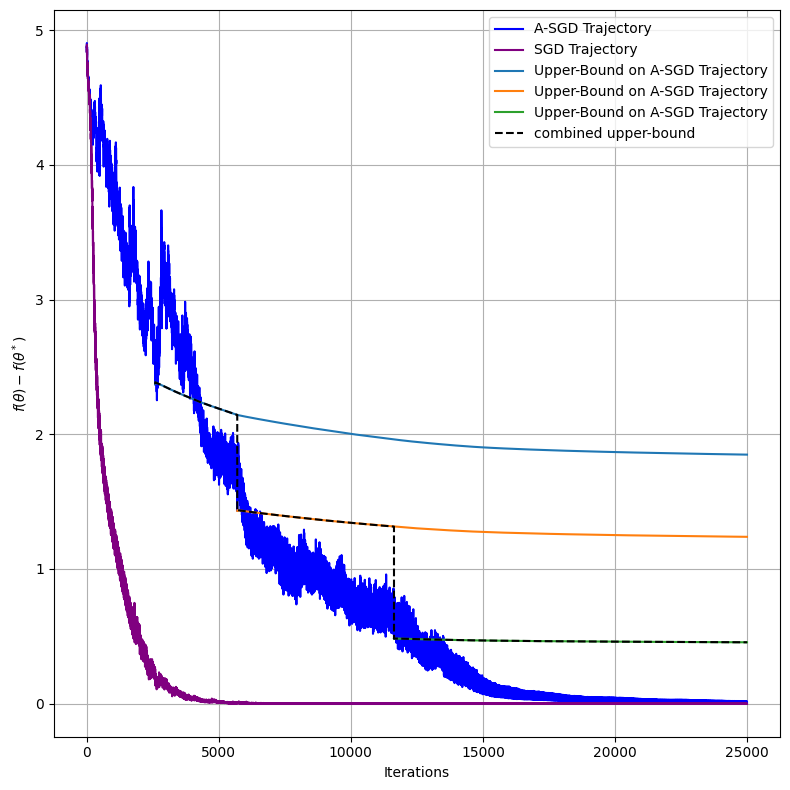

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(trajectory_f_1_async, c = 'blue', label = 'A-SGD Trajectory')

if enable_sgd:
    ax1.plot(trajectory_f_1_sync, c = 'purple', label = 'SGD Trajectory')
if enable_dcasgd:
    ax1.plot(trajectory_f_1_dcasgd, c = 'red', label = 'DC-ASGD Trajectory')

for bound in bounds_1:
    if not (np.all(np.isnan(bound)) or np.all(np.isinf(bound))):
        ax1.plot(bound, label = 'Upper-Bound on A-SGD Trajectory')

ax1.plot(lu_bound, ls = '--', color = 'k', label = 'combined upper-bound')

ax1.legend()
ax1.grid(which = 'both')
ax1.set_xlabel("Iterations")
ax1.set_ylabel(r"$f(\theta) - f(\theta^*)$")
plt.tight_layout()

In [31]:
fig.savefig("./asgd_multi_bounds.pdf")

In [26]:
save_dict = {
                'trajectory_f_1_async'      : trajectory_f_1_async,
                'trajectory_f_1_sync'       : trajectory_f_1_sync,
                'trajectory_f_1_dcasgd'     : trajectory_f_1_dcasgd,
                'bounds_1'                  : bounds_1, 
                'kappa_values'              : kappa_values,
                'learning_rates_schedule'   : learning_rates_schedule, 
                'mu'                        : mu,    
                'L'                         : L,
                'f0_diff'                   : f0_diff,
                'sigma_sq'                  : sigma_sq,
                'k'                         : k,
                'G_locals'                  : G_locals,
                'tau_Ms'                    : tau_Ms,
                'grad_norms_collected'      : grad_norms_collected      
            }

np.savez('params', **save_dict)

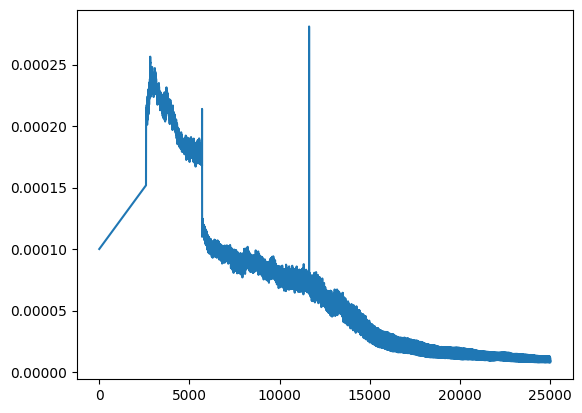

In [27]:
plt.plot(learning_rates_schedule)